# Projeto Marinha do Brasil

## Laboratório de Processamento de Sinais - UFRJ

### Autor: Vinícius dos Santos Mello <viniciusdsmello@poli.ufrj.br>

In [1]:
import os
import sys
import pickle
import numpy as np
import time

from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K

import sklearn.metrics
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt

import multiprocessing

from Functions import TrainParameters as trnparams
from Functions import TrainFunctions
from Functions.StackedAutoEncoders import StackedAutoEncoders
from Functions import FunctionsDataVisualization
from Functions.StatisticalAnalysis import KLDiv, EstPDF
from SAENoveltyDetectionAnalysis import SAENoveltyDetectionAnalysis

num_processes = multiprocessing.cpu_count()

analysis_name = 'StackedAutoEncoder'

# Enviroment variables
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

# paths to export results
base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/pictures_files'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

analysis = SAENoveltyDetectionAnalysis(analysis_name="StackedAutoEncoder")

Using TensorFlow backend.


[+] Time to read data file: 1.20638895035 seconds
Qtd event of A is 12939
Qtd event of B is 29352
Qtd event of C is 11510
Qtd event of D is 23760

Biggest class is B with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


#### Importing the dataset

In [2]:
all_data, all_trgt, trgt_sparse = analysis.getData()

#### Load the train parameters file

In [5]:
trn_params = analysis.getTrainParameters()

Reading from /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/10_folds_cross_validation.jbl

2_inits_mapstd_norm_300_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss


#### Initialize objects of StackedAutoEncoder class for all models with its corresponding novelty class

In [6]:
analysis.createSAEModels()
SAE, trn_data, trn_trgt, trn_trgt_sparse = analysis.getSAEModels()

[*] Initializing SAE Class for class A
[*] Initializing SAE Class for class B
[*] Initializing SAE Class for class C
[*] Initializing SAE Class for class D


#### Perform the training of the model

In [ ]:
%time
# python modelTrain.py --layer 1 --novelty 0 --type "neuronSweep" --finetunning 0
#%run -i 'modelTrain.py' --layer 1 --novelty 1 --regularizer dropout --paramvalue 0.5 --type "neuronSweep" --finetunning 1

# Pre-training analysis

### Kullback-Leibler Divergence analysis for a neuron variation at autoencoder

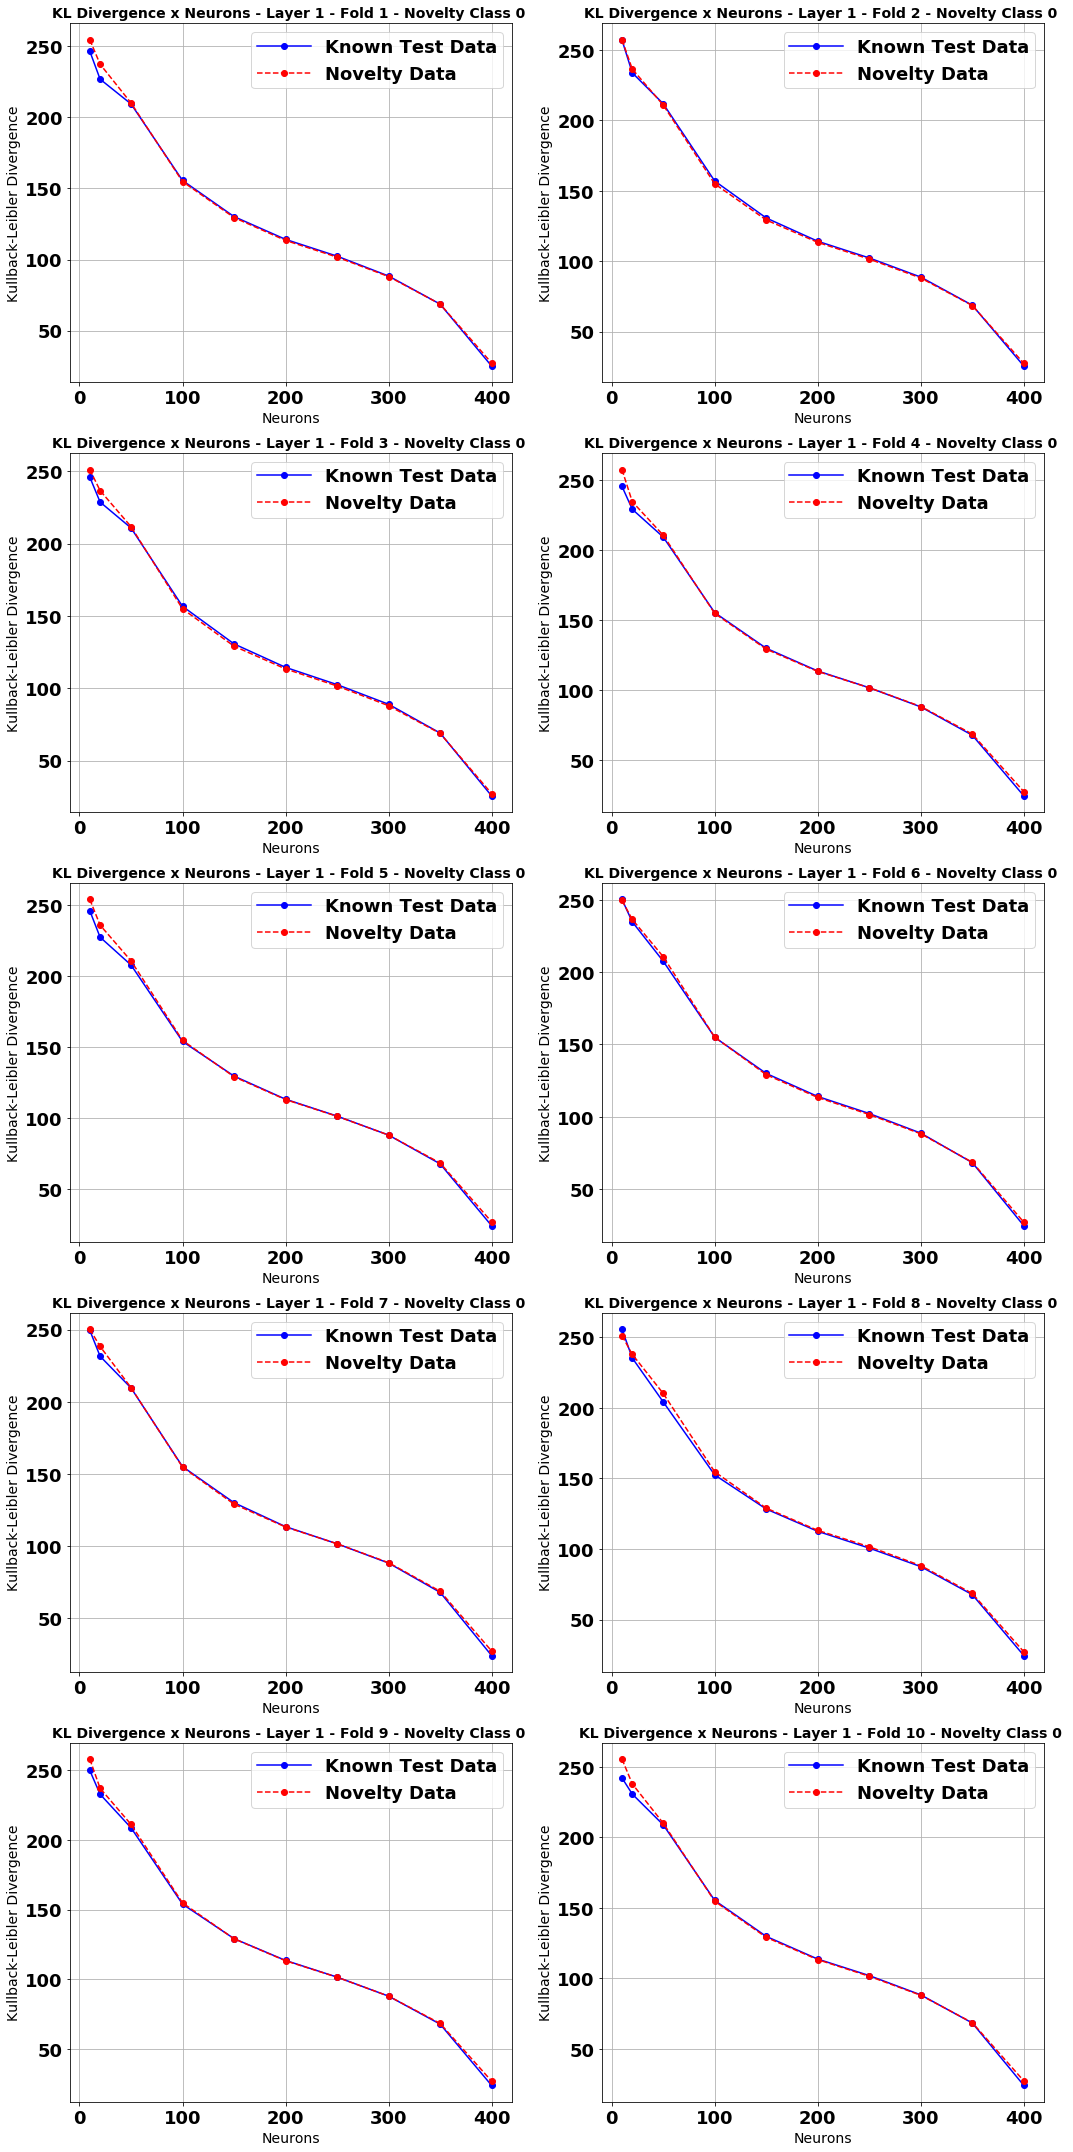

In [22]:
# Neuron variation x KL Divergence

%matplotlib inline 

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

neurons_mat = [10,20] + range(50,450,50)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

# Choose model
inovelty = 0
regularizer = "dropout"
regularizer_param = 0.500000

# generate analysis data
save_path=results_path

current_analysis = 'klDivergence_%i_layer_%i_novelty'%(layer, inovelty)
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
if regularizer != None or len(regularizer) != 0:
    analysis_file_name='%s/%s/%s_%s_regularizer(%f)_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,regularizer,
                                                                                 regularizer_param,current_analysis)
else:
    analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

n_folds = analysis.n_folds

klDivergenceFreq = {}
klDivergenceKnown = np.zeros([n_folds, len(neurons_mat)], dtype=object)
klDivergenceKnownFreq = {}
klDivergenceNovelty = np.zeros([n_folds, len(neurons_mat)], dtype=object)
klDivergenceNoveltyFreq = {}

# if os.path.exists(analysis_file_name):
#     os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    for ineuron in neurons_mat: 
        if ineuron == 0:
            ineuron = 1
        neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer-1]+[ineuron])

        models = {}
        outputs = {}
        norm_data = {}
        reconstructed_known_data = {}
        reconstructed_novelty_data = {}
        if verbose: 
            print '[*] Layer: %i - Topology: %s'%(layer, neurons_str)

        n_bins = 100

        def getKlDiv(ifold):
            train_id, test_id = analysis.CVO[inovelty][ifold]

            # normalize known classes
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

            known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
            novelty_data = scaler.transform(all_data[all_trgt==inovelty])

            model = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                           hidden_neurons=hidden_neurons[:layer-1]+[ineuron],
                                           layer=layer, ifold=ifold, regularizer=regularizer, regularizer_param=regularizer_param)

            known_output = model.predict(known_data)
            novelty_output = model.predict(novelty_data)

            klKnown = np.zeros([all_data.shape[1]], dtype=object)
            klNovelty = np.zeros([all_data.shape[1]], dtype=object)
            
            for ifrequency in range(0,400):
                # Calculate KL Div for known data reconstruction
                known_data_freq = known_data[:,ifrequency]
                reconstructed_known_data = known_output[:,ifrequency]

                m_bins = np.linspace(known_data_freq.min(), known_data_freq.max(), n_bins)
                
                klKnown[ifrequency] = KLDiv(known_data_freq.reshape(-1,1), reconstructed_known_data.reshape(-1,1),
                                       bins=m_bins, mode='kernel', kernel='epanechnikov',
                                       kernel_bw=0.1, verbose=False)

                klKnown[ifrequency] = klKnown[ifrequency][0]
                
                # Calculate KL Div for novelty data reconstruction
                novelty_data_freq = novelty_data[:,ifrequency]
                reconstructed_novelty_data = novelty_output[:,ifrequency]

                m_bins = np.linspace(novelty_data_freq.min(), novelty_data_freq.max(), n_bins)
                
                klNovelty[ifrequency] = KLDiv(novelty_data_freq.reshape(-1,1), reconstructed_novelty_data.reshape(-1,1),
                                       bins=m_bins, mode='kernel', kernel='epanechnikov',
                                       kernel_bw=0.1, verbose=False)

                klNovelty[ifrequency] = klNovelty[ifrequency][0]
                
            return ifold, klKnown, klNovelty

        # Start Parallel processing
        p = multiprocessing.Pool(processes=num_processes)

        folds = range(n_folds)
        if verbose:
            print '[*] Calculating KL Div for all frequencies...'
        # Calculate the KL Div at all frequencies
        klDivergenceFreq[ineuron] = p.map(getKlDiv, folds)
        
        p.close()
        p.join()
        
        index = neurons_mat.index(ineuron)
        for ifold in range(n_folds):
            klDivergenceKnownFreq = klDivergenceFreq[ineuron][ifold][1]
            klDivergenceNoveltyFreq = klDivergenceFreq[ineuron][ifold][2]
            
            klDivergenceKnown[ifold, index] = np.sum(klDivergenceKnownFreq)
            klDivergenceNovelty[ifold, index] = np.sum(klDivergenceNoveltyFreq)

        joblib.dump([neurons_mat,klDivergenceKnown,klDivergenceNovelty],analysis_file_name,compress=9)
else:
    [neurons_mat, klDivergenceKnown, klDivergenceNovelty] = joblib.load(analysis_file_name)
# Plot results    
fig, m_ax = plt.subplots(figsize=(15,30),nrows=5, ncols=2)

for ifold in range(n_folds):
    irow = int(ifold/2)
    if (ifold % 2 == 0):
        icolumn = 0
    else: 
        icolumn = 1

    m_ax[irow, icolumn].plot(neurons_mat, klDivergenceKnown[ifold,:], 'b-o', label='Known Test Data')
    m_ax[irow, icolumn].plot(neurons_mat, klDivergenceNovelty[ifold,:], 'r--o', label='Novelty Data')
    m_ax[irow, icolumn].set_title('KL Divergence x Neurons - Layer %i - Fold %i - Novelty Class %i '%(layer,ifold+1, inovelty), fontsize=14, fontweight='bold')
    m_ax[irow, icolumn].set_ylabel('Kullback-Leibler Divergence', fontsize=14)
    m_ax[irow, icolumn].set_xlabel('Neurons', fontsize=14)
    m_ax[irow, icolumn].grid()
    m_ax[irow, icolumn].legend()
    plt.tight_layout()
plt.show()

## Mean Squared Error analysis for Pre-training Step with a neuron variation at autoencoder

[*] Layer: 1 - Topology: 400x10
[*] Calculating Mean Squared Error ...
/home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/RawData_1_novelty_10_folds_2_inits_mapstd_norm_300_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss_400x10_neurons_l2_regularizer(0.500000)
/home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/RawData_1_novelty_10_folds_2_inits_mapstd_norm_300_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss_400x10_neurons_l2_regularizer(0.500000)
/home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/RawData_1_novelty_10_folds_2_inits_mapstd_norm_300_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss_400x10_neurons_l2_regularizer(0.500000)
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Novelt

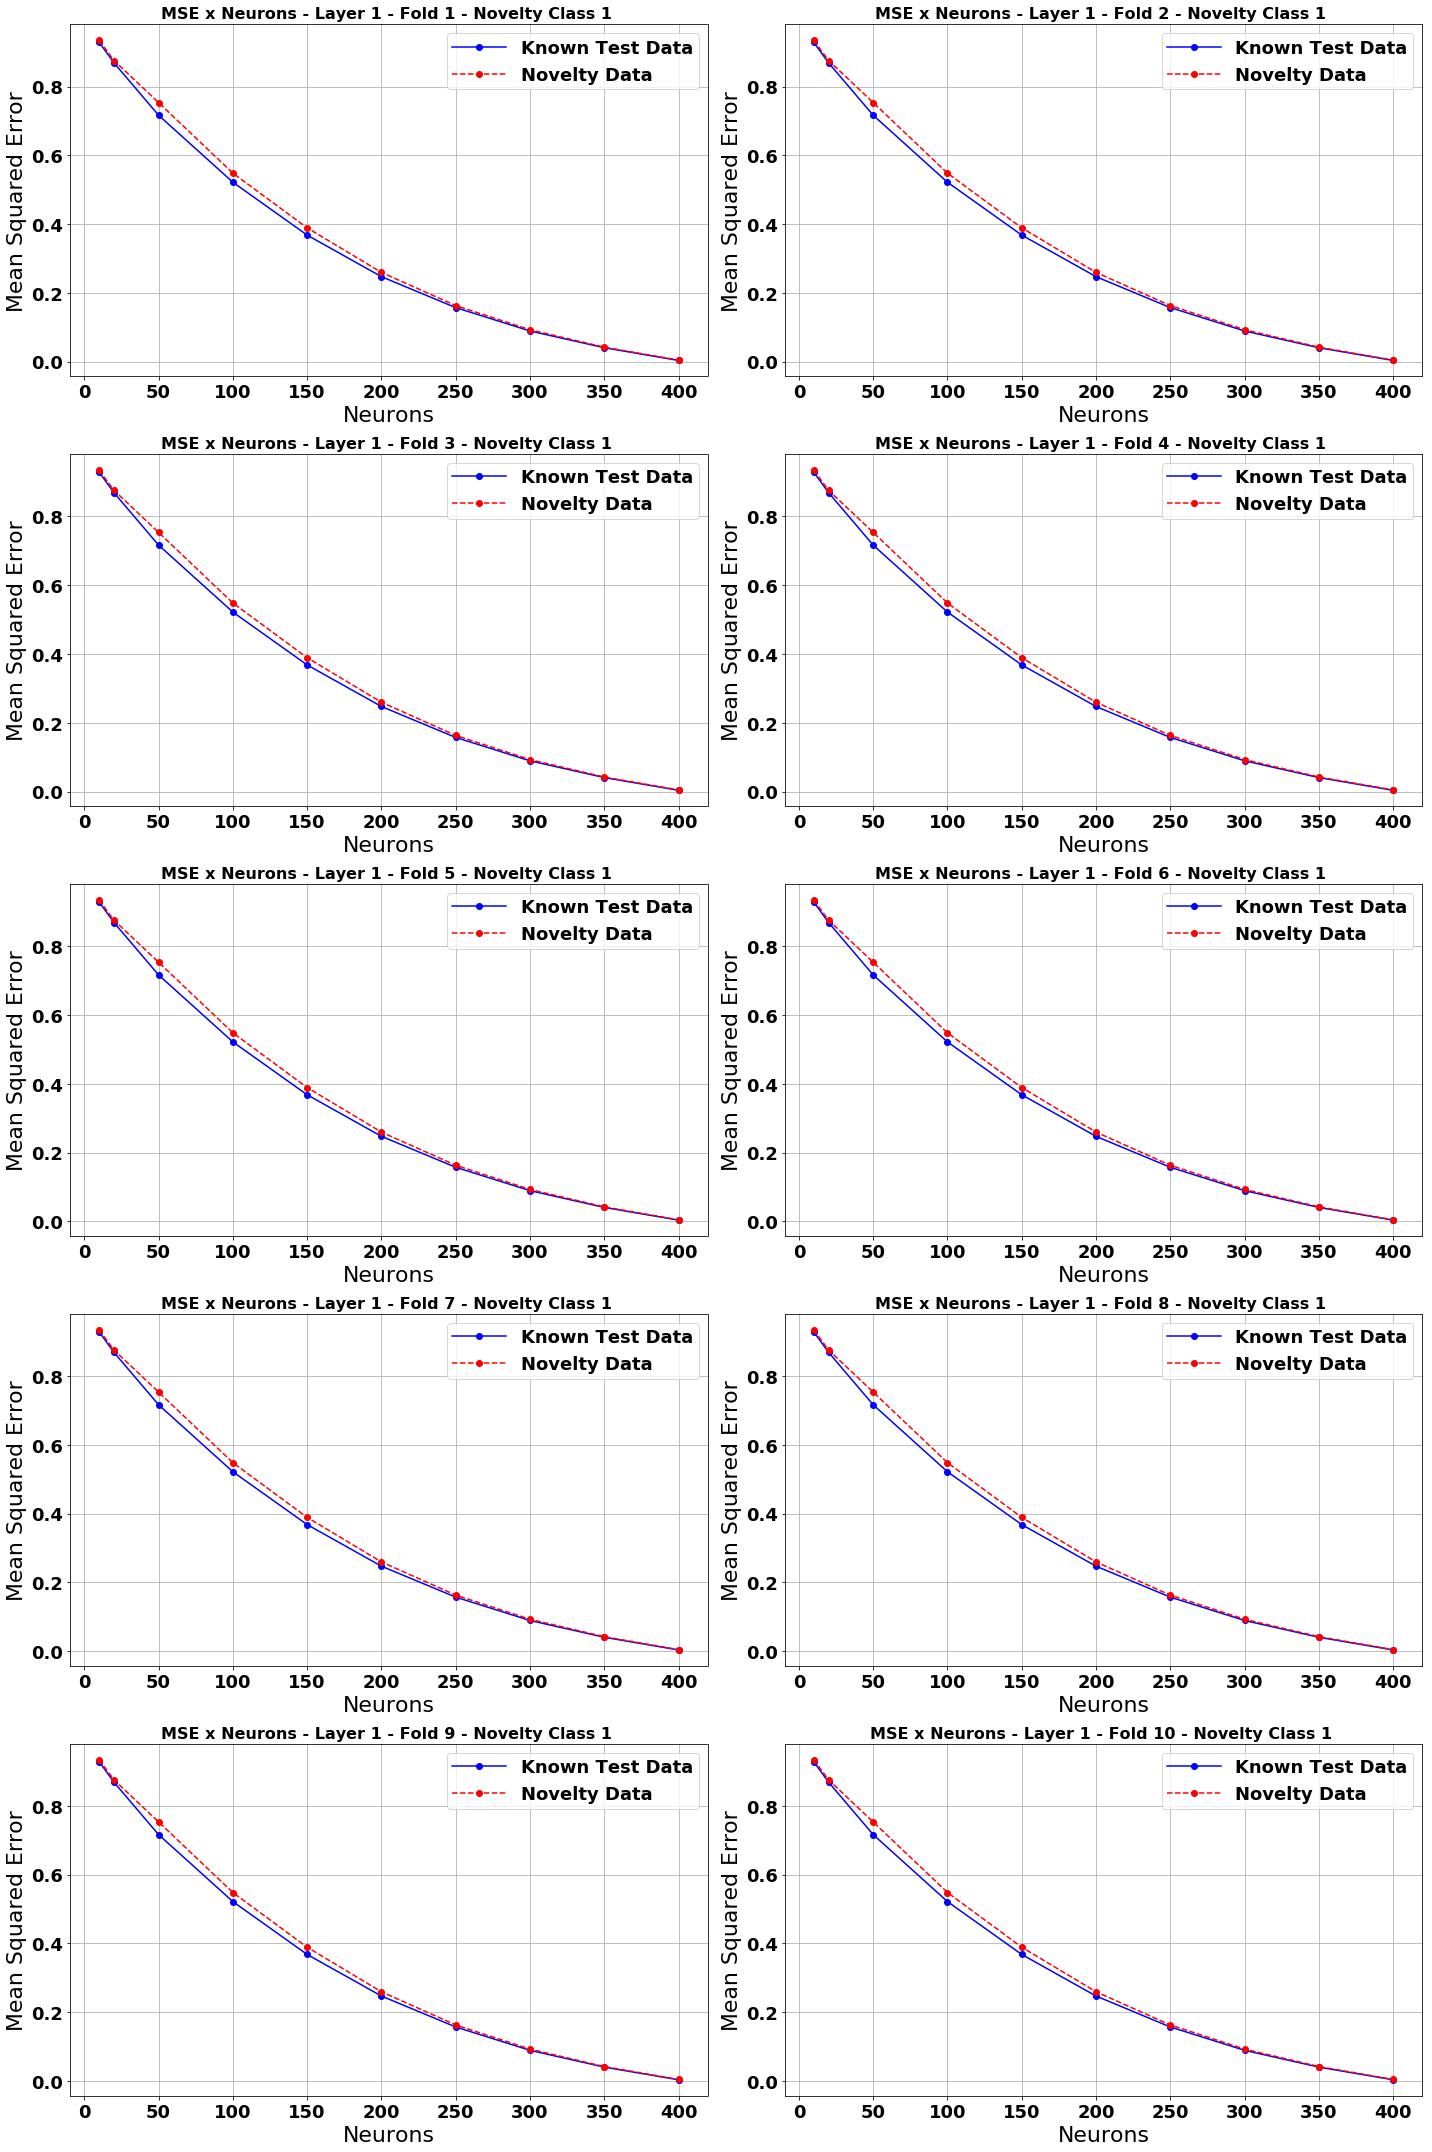

2_inits_mapstd_norm_300_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss
400x400 neurons


<Figure size 432x288 with 0 Axes>

In [15]:
# Neuron variation x KL Divergence
%matplotlib inline 

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

neurons_mat = [10, 20] + range(50,450,50)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

# Choose model
inovelty = 1
regularizer = "l2"
regularizer_param = 0.500000

# generate analysis data
save_path=results_path

current_analysis = 'mean_squared_error_%i_layer_%i_novelty'%(layer, inovelty)
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

if regularizer != None or len(regularizer) != 0:
    analysis_file_name='%s/%s/%s_%s_regularizer(%f)_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,regularizer,
                                                                                 regularizer_param,current_analysis)
else:
    analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = analysis.trn_params.get_params_str()

n_folds = analysis.n_folds

mse = {}
mse_known = np.zeros([n_folds, len(neurons_mat)])
mse_novelty = np.zeros([n_folds, len(neurons_mat)])

# if os.path.exists(analysis_file_name):
#     os.remove(analysis_file_name)
    
if not os.path.exists(analysis_file_name):
    for ineuron in neurons_mat: 
        if ineuron == 0:
            ineuron = 1
        neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer-1]+[ineuron])

        models = {}
        outputs = {}
        norm_data = {}
        reconstructed_known_data = {}
        reconstructed_novelty_data = {}
        if verbose: 
            print '[*] Layer: %i - Topology: %s'%(layer, neurons_str)

        n_bins = 100

        def getMSE(ifold):
            train_id, test_id = analysis.CVO[inovelty][ifold]

            # normalize known classes
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

            known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
            novelty_data = scaler.transform(all_data[all_trgt==inovelty])

            model = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                           hidden_neurons=hidden_neurons[:layer-1]+[ineuron],
                                           layer=layer, ifold=ifold, regularizer=regularizer, regularizer_param=regularizer_param)

            known_output = model.predict(known_data)
            novelty_output = model.predict(novelty_data)
            
            mseKnown = metrics.mean_squared_error(known_data, known_output)
            mseNovelty = metrics.mean_squared_error(novelty_data, novelty_output)
            
                
            return ifold, mseKnown, mseNovelty

        # Start Parallel processing
        p = multiprocessing.Pool(processes=num_processes)

        folds = range(n_folds)
        if verbose:
            print '[*] Calculating Mean Squared Error ...'
        mse[ineuron] = p.map(getMSE, folds)
        
        for ifold in range(n_folds):
            mse_known[:, neurons_mat.index(ineuron)] = mse[ineuron][ifold][1]
            mse_novelty[:, neurons_mat.index(ineuron)] = mse[ineuron][ifold][2]
        
        p.close()
        p.join()
    
        joblib.dump([neurons_mat,mse_known,mse_novelty],analysis_file_name,compress=9)
else:
    [neurons_mat, mse_known, mse_novelty] = joblib.load(analysis_file_name)
# Plot results    
fig, m_ax = plt.subplots(figsize=(20,30),nrows=5, ncols=2)

for ifold in range(n_folds):
    irow = int(ifold/2)
    if (ifold % 2 == 0):
        icolumn = 0
    else: 
        icolumn = 1

    m_ax[irow, icolumn].plot(neurons_mat, mse_known[ifold, :], 'b-o', label='Known Test Data')
    m_ax[irow, icolumn].plot(neurons_mat, mse_novelty[ifold, :], 'r--o', label='Novelty Data')
    m_ax[irow, icolumn].set_title('MSE x Neurons - Layer %i - Fold %i - Novelty Class %i '%(layer,ifold+1, inovelty), fontsize=16, fontweight='bold')
    m_ax[irow, icolumn].set_ylabel('Mean Squared Error', fontsize=22)
    m_ax[irow, icolumn].set_xlabel('Neurons', fontsize=22)
    m_ax[irow, icolumn].grid()
    m_ax[irow, icolumn].legend()
    plt.tight_layout()
plt.show()
#Save the figure
file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_%s_neurons_'%(inovelty,neurons_str)+trn_params.get_params_str()+'.pdf'
plt.savefig(file_name)
print trn_params.get_params_str()
print '%s neurons'%neurons_str

## Receiver Operating Characteristic (ROC) Curve for SP/Trigger with Novelty Detection

In [ ]:
from __future__ import unicode_literals

# Choose layer
layer = 1
inovelty = 1

# Choose neurons topology for SAE
hidden_neurons = range(400,0,-50) + [2]

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_novelty_detection_%s_neurons_thr_sweep.jbl'%(results_path,analysis_str,analysis_name, neurons_str)

if not os.path.exists(analysis_file_name):

    params_str = trn_params.get_params_str()

    thr_mat = np.round(np.arange(-0.0,1.05,0.05),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(thr_mat)])

    class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
    novelty_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_acc = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_trig = np.zeros([len(np.unique(all_trgt))], dtype=object)

    def getFiguresMetrics(inovelty):
        n_folds = len(CVO[inovelty])  
        print 'Novelty class: %01.0f - topology: %s'%(inovelty, neurons_str)
        for ifold in range(n_folds):
            classifier = SAE[inovelty].loadClassifier(data  = trn_data[inovelty],
                                                      trgt  = trn_trgt[inovelty], 
                                                      hidden_neurons = hidden_neurons[:layer],
                                                      layer = layer,
                                                      ifold = ifold)

            train_id, test_id = CVO[inovelty][ifold]
            # normalize known classes
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(trn_data[inovelty][train_id,:])

            known_data = scaler.transform(trn_data[inovelty][test_id,:])
#             known_data = trn_data[inovelty][test_id,:]
            known_trgt = trn_trgt[inovelty][test_id]

            novelty_data = scaler.transform(all_data[all_trgt==inovelty])
#             novelty_data = all_data[all_trgt==inovelty]

            output = classifier.predict(known_data)
            novelty_output = classifier.predict(novelty_data)

            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, iclass, ithr]
                novelty_eff_mat[ifold, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))

        return inovelty, class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat

    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)

    results = p.map(getFiguresMetrics, class_labels.keys())

    p.close()
    p.join()         

    for inovelty in class_labels.keys():
        if inovelty == results[inovelty][0]:
            class_eff[inovelty]   = results[inovelty][1]
            novelty_eff[inovelty] = results[inovelty][2]
            known_acc[inovelty]   = results[inovelty][3]
            known_sp[inovelty]    = results[inovelty][4]
            known_trig[inovelty]  = results[inovelty][5]

    joblib.dump([class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'File exists'
    [class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  


plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    fig = plt.subplots(figsize=(12,6))
    ax = plt.subplot(1,1,1)
    
    xdata1 = np.ones(np.mean(known_sp[inovelty], axis=0).shape) - np.mean(known_sp[inovelty], axis=0)
    xdata2 = np.ones(np.mean(known_sp[inovelty], axis=0).shape) - np.mean(known_trig[inovelty], axis=0)
        
    ax.errorbar(xdata1, np.mean(novelty_eff[inovelty], axis=0),
                np.std(novelty_eff[inovelty], axis=0),fmt='o-',
                color='r',alpha=0.7,linewidth=2.5,
                label='ROC SP')
    ax.errorbar(xdata2, np.mean(novelty_eff[inovelty], axis=0),
                np.std(novelty_eff[inovelty], axis=0),fmt='d-',
                color='b',alpha=0.7,linewidth=2.5,
                label='ROC Trigger')
#     ax.errorbar(thr_mat,np.mean(known_acc[inovelty], axis=0),
#                 np.std(known_acc[inovelty], axis=0),fmt='o--',
#                 color='k',alpha=0.7,linewidth=2.5,
#                 label='Known Acc.')
    ax.set_xticks(np.arange(0,1.25,0.25))
    ax.set_xticklabels(np.arange(0,1.25,0.25),rotation=45, fontsize=18)
    ax.set_title('SAE com %i camada treinado com a classe %s como Novidade'%(layer,class_labels_txt[inovelty]),fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    
    ax.set_ylim([0.0, 1.2])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(np.round(y_ticks,2))
    ax.set_yticklabels(100*np.round(y_ticks,2)[np.round(y_ticks,2)<=1.0],fontsize=18)
    
    ax.grid()
    
    ax.set_xlabel('(1 - SP) (%s)',fontsize=20,weight='bold')
    ax.set_ylabel('Detecção de Novidade (%)',fontsize=20,weight='bold')

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')
    
    plt.show()
    #Save the figure
    file_name = pict_results_path+'/'+"ROC_sp_novelty_det"+'_%i_novelty_%s_neurons_'%(inovelty,neurons_str)+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print trn_params.get_params_str()
print '%s neurons'%neurons_str